In [ ]:
!pip install torch torchvision
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay


In [ ]:
project_dir = '/content/drive/My Drive/VGG_CIFAR10'
os.makedirs(project_dir, exist_ok=True)


In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:03<00:00, 43871000.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AdaptiveAvgPool2d((1, 1))]
        return nn.Sequential(*layers)

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = VGG('VGG19').to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


In [ ]:
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
f1_history = []
precision_history = []
recall_history = []

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


In [ ]:
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    train_loss_history.append(train_loss / len(trainloader))
    train_acc_history.append(100. * correct / total)
    f1_history.append(f1_score(all_targets, all_predictions, average='macro'))
    precision_history.append(precision_score(all_targets, all_predictions, average='macro'))
    recall_history.append(recall_score(all_targets, all_predictions, average='macro'))

    print(f'Epoch {epoch} | Train Loss: {train_loss / len(trainloader):.3f} | Train Acc: {100. * correct / total:.3f}%')


In [ ]:
def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_loss_history.append(test_loss / len(testloader))
    test_acc_history.append(100. * correct / total)
    f1_history.append(f1_score(all_targets, all_predictions, average='macro'))
    precision_history.append(precision_score(all_targets, all_predictions, average='macro'))
    recall_history.append(recall_score(all_targets, all_predictions, average='macro'))

    print(f'Epoch {epoch} | Test Loss: {test_loss / len(testloader):.3f} | Test Acc: {100. * correct / total:.3f}%')

    global best_acc
    acc = 100. * correct / total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        torch.save(state, f'{project_dir}/ckpt.pth')
        torch.save({
            'train_loss': train_loss_history,
            'train_acc': train_acc_history,
            'test_loss': test_loss_history,
            'test_acc': test_acc_history,
            'f1': f1_history,
            'precision': precision_history,
            'recall': recall_history,
        }, f'{project_dir}/history.pth')
        best_acc = acc


In [ ]:
# Check for checkpoint file
ckpt_path = f'{project_dir}/ckpt.pth'
history_path = f'{project_dir}/history.pth'
if os.path.exists(ckpt_path):
    print('==> Resuming from checkpoint..')
    checkpoint = torch.load(ckpt_path)
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch'] + 1

    # Load history
    if os.path.exists(history_path):
        history = torch.load(history_path)
        train_loss_history = history['train_loss']
        train_acc_history = history['train_acc']
        test_loss_history = history['test_loss']
        test_acc_history = history['test_acc']
        f1_history = history['f1']
        precision_history = history['precision']
        recall_history = history['recall']
else:
    print('==> No checkpoint found, starting from scratch..')

# Training Loop
for epoch in range(start_epoch, start_epoch + 200):
    train(epoch)
    test(epoch)
    scheduler.step()


==> No checkpoint found, starting from scratch..
Epoch 0 | Train Loss: 2.496 | Train Acc: 10.174%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0 | Test Loss: 2.301 | Test Acc: 10.180%
Saving..
Epoch 1 | Train Loss: 2.300 | Train Acc: 10.686%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 | Test Loss: 2.298 | Test Acc: 10.760%
Saving..
Epoch 2 | Train Loss: 2.298 | Train Acc: 10.650%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2 | Test Loss: 2.293 | Test Acc: 11.210%
Saving..
Epoch 3 | Train Loss: 2.293 | Train Acc: 10.996%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3 | Test Loss: 2.296 | Test Acc: 11.550%
Saving..
Epoch 4 | Train Loss: 1.971 | Train Acc: 21.406%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4 | Test Loss: 1.863 | Test Acc: 24.810%
Saving..
Epoch 5 | Train Loss: 1.688 | Train Acc: 33.124%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5 | Test Loss: 1.815 | Test Acc: 35.880%
Saving..
Epoch 6 | Train Loss: 1.368 | Train Acc: 48.698%
Epoch 6 | Test Loss: 1.661 | Test Acc: 44.920%
Saving..
Epoch 7 | Train Loss: 1.099 | Train Acc: 60.266%
Epoch 7 | Test Loss: 1.087 | Test Acc: 62.460%
Saving..
Epoch 8 | Train Loss: 0.951 | Train Acc: 66.822%
Epoch 8 | Test Loss: 0.898 | Test Acc: 69.940%
Saving..
Epoch 9 | Train Loss: 0.865 | Train Acc: 70.692%
Epoch 9 | Test Loss: 0.893 | Test Acc: 68.680%
Epoch 10 | Train Loss: 0.793 | Train Acc: 73.742%
Epoch 10 | Test Loss: 1.005 | Test Acc: 67.910%
Epoch 11 | Train Loss: 0.756 | Train Acc: 75.292%
Epoch 11 | Test Loss: 1.028 | Test Acc: 67.980%
Epoch 12 | Train Loss: 0.717 | Train Acc: 76.666%
Epoch 12 | Test Loss: 0.993 | Test Acc: 68.480%
Epoch 13 | Train Loss: 0.679 | Train Acc: 77.772%
Epoch 13 | Test Loss: 1.079 | Test Acc: 66.930%
Epoch 14 | Train Loss: 0.669 | Train Acc: 78.582%
Epoch 14 | Test Loss: 0.965 | Test Acc: 70.100%
Saving..
Epoch 15 | Train Loss: 0.642 | Tra

<ipython-input-17-6ed884b08397>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=torch.device('cpu'))
<ipython-input-17-6ed884b08

Checkpoint Contents:
Epoch: 179
Accuracy: 93.58
Model State Dict Keys:
odict_keys(['features.0.weight', 'features.0.bias', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.3.bias', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.7.bias', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.10.bias', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.14.bias', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.17.bias', 'features.18.weight', 'fea

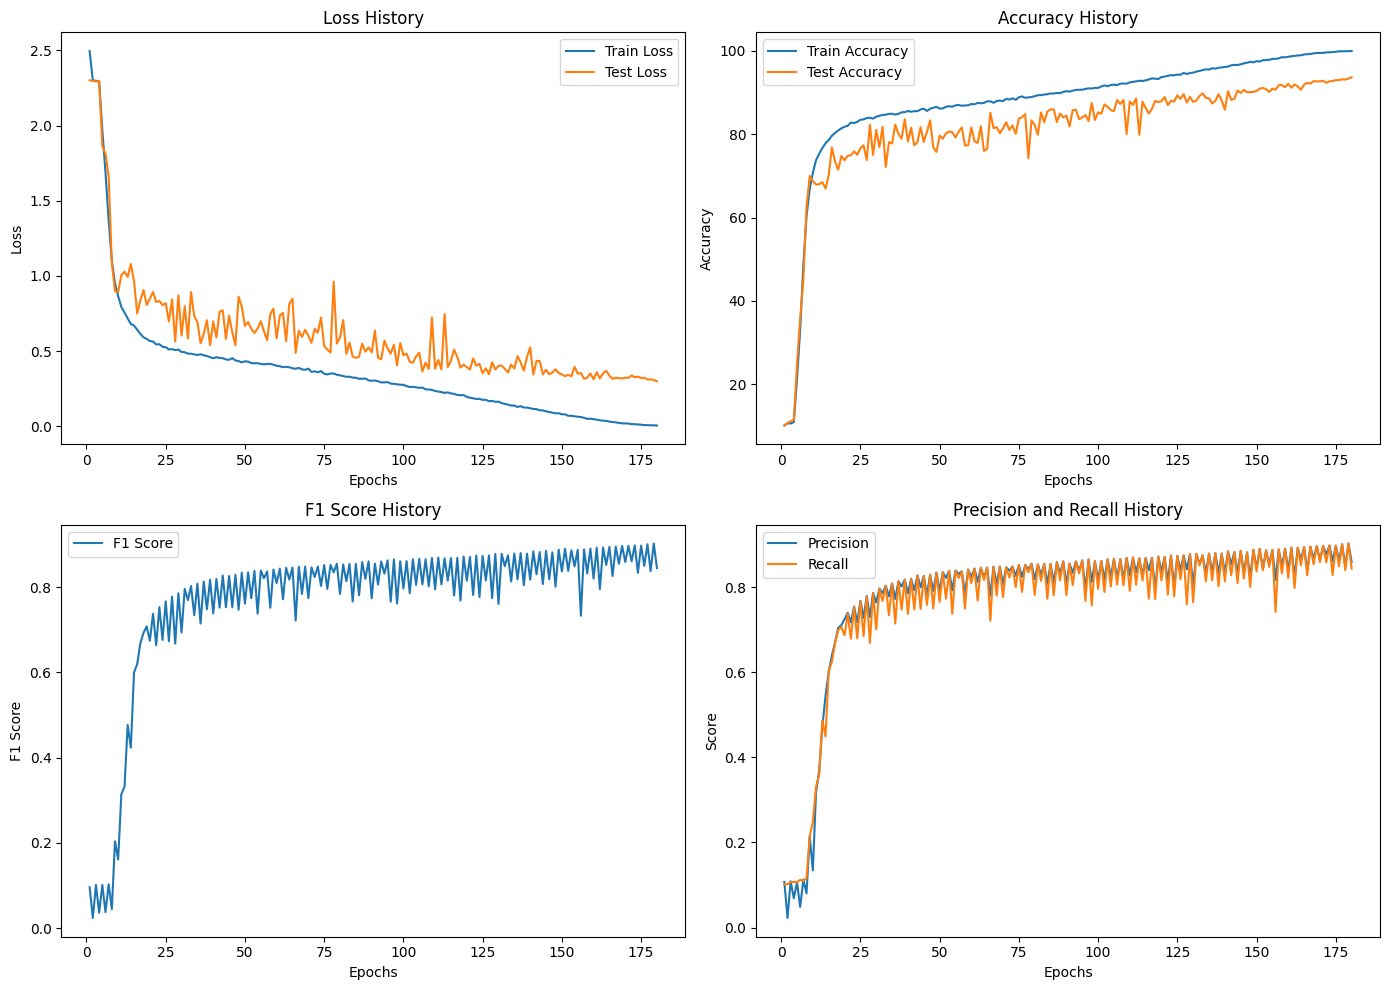

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the project directory (extracted from the provided file)
project_dir = '/content/drive/My Drive/VGG_CIFAR10'
ckpt_path = f'{project_dir}/ckpt.pth'
history_path = f'{project_dir}/history.pth'

# Load functions
def load_checkpoint(path):
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    return checkpoint

def load_history(path):
    history = torch.load(path, map_location=torch.device('cpu'))
    return history

# Print functions
def print_checkpoint(checkpoint):
    print("Checkpoint Contents:")
    print(f"Epoch: {checkpoint['epoch']}")
    print(f"Accuracy: {checkpoint['acc']}")
    print("Model State Dict Keys:")
    print(checkpoint['net'].keys())

def print_history(history):
    print("History Contents:")
    print(history.keys())
    for key, value in history.items():
        print(f"{key}: {value[:5]}...")  # Print first 5 entries for brevity

# Plotting functions
def plot_history(history):
    min_length = min(len(history['train_loss']), len(history['test_loss']),
                     len(history['train_acc']), len(history['test_acc']),
                     len(history['f1']), len(history['precision']), len(history['recall']))

    epochs = range(1, min_length + 1)

    # Plot Loss
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_loss'][:min_length], label='Train Loss')
    plt.plot(epochs, history['test_loss'][:min_length], label='Test Loss')
    plt.title('Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train_acc'][:min_length], label='Train Accuracy')
    plt.plot(epochs, history['test_acc'][:min_length], label='Test Accuracy')
    plt.title('Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot F1 Score
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['f1'][:min_length], label='F1 Score')
    plt.title('F1 Score History')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Plot Precision and Recall
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['precision'][:min_length], label='Precision')
    plt.plot(epochs, history['recall'][:min_length], label='Recall')
    plt.title('Precision and Recall History')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{project_dir}/training_plots.png')
    plt.show()

def main():
    # Load and print checkpoint
    checkpoint = load_checkpoint(ckpt_path)
    print_checkpoint(checkpoint)

    # Load and print history
    history = load_history(history_path)
    print_history(history)

    # Plot metrics
    plot_history(history)

    # Compute and print confusion matrix for the best/latest epoch
    # Assuming the last entry contains the targets and predictions
    y_true = history.get('targets', [None])[-1]
    y_pred = history.get('predictions', [None])[-1]
    if y_true is not None and y_pred is not None:
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.show()

if __name__ == "__main__":
    main()


<ipython-input-16-163aaca3c1bd>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'{project_dir}/ckpt.pth')


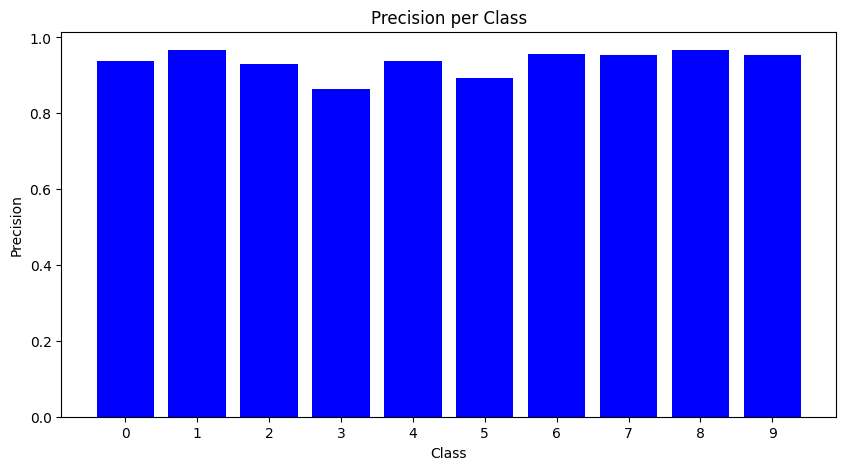

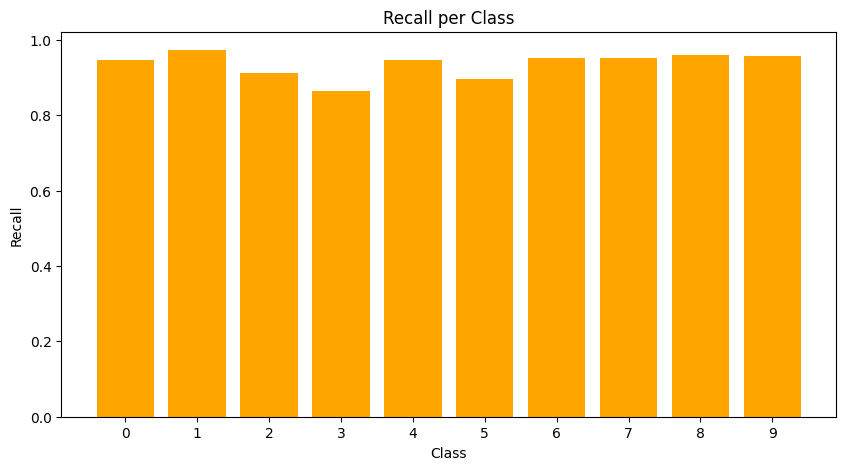

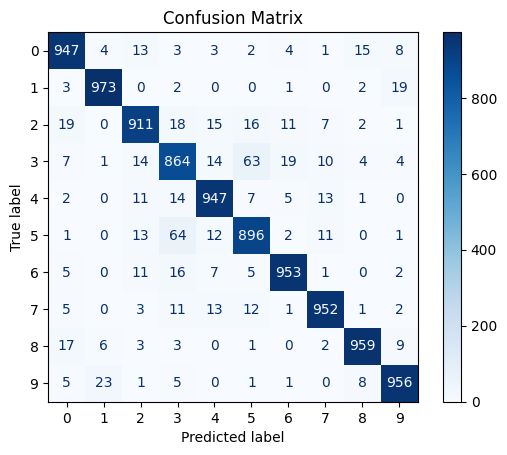

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

# Load best model
checkpoint = torch.load(f'{project_dir}/ckpt.pth')
net.load_state_dict(checkpoint['net'])

# Function to compute precision, recall, and confusion matrix
def compute_metrics(loader):
    net.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    precision, recall, _, _ = precision_recall_fscore_support(all_targets, all_predictions, average=None)
    cm = confusion_matrix(all_targets, all_predictions)
    return precision, recall, cm

# Compute precision, recall, and confusion matrix for test data
precision, recall, cm = compute_metrics(testloader)

# Generate a timestamp to uniquely name the plots
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Plot precision matrix
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(precision)), precision, color='blue')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision per Class')
plt.xticks(np.arange(len(precision)), np.arange(len(precision)))
plt.savefig(f'{project_dir}/precision_matrix_{timestamp}.png')
plt.show()

# Plot recall matrix
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(recall)), recall, color='orange')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall per Class')
plt.xticks(np.arange(len(recall)), np.arange(len(recall)))
plt.savefig(f'{project_dir}/recall_matrix_{timestamp}.png')
plt.show()

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig(f'{project_dir}/confusion_matrix_{timestamp}.png')
plt.show()
